# Dimensionality Reduction Using Principal Component Analysis

In [2]:
import sys
import os
from datetime import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn

print('Python version     :', '{0[0]}.{0[1]}'.format(sys.version_info))
print('Tensorflow version :', tf.__version__)
print('numpy version      :', np.__version__)
np.random.seed(0)
tf.random.set_seed(2)

Python version     : 3.9
Tensorflow version : 2.9.1
numpy version      : 1.20.3


## Dataset

Our dataset consists of total of over 12,000 cells with a total of 2 categories; over 2,000 cells in sequential category (labelled SQNC) and over 10,000 in combinational category (labelled COMB). Each cell in the dataset is represented as a 2D matrix of transistor devices and their parameters given below:


| Device | param1 | param2 | param3 | param4 | param5 | ...... | ...... | param13 |
|--------|--------|--------|--------|--------|--------|--------|--------|---------|
|   10   |    6   |    6   |    3   |    3   |    5   |        |        |    2    |
|   10   |    8   |    3   |    2   |    4   |    4   |    2   |    3   |    6    |
|   20   |    7   |    3   |    2   |    4   |    4   |    2   |    3   |    2    |
|  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...    |
|  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...    |
|   20   |    7   |    3   |    2   |    4   |    5   |    2   |    3   |    2    |


Entire dataset consists of 20,000 such tables is shown in the next picture.


![Cell Dataset As Stack Of Tables](https://github.com/srohit0/mida/blob/master/data/CellDatasetAsStackOfTables.jpg?raw=true)

# Feature Selection

Each cell in the dataset has size of 351x14, which gives us dimension of approximately 5000 features. As a domain expert in the circuit analysis we’ve identified column 0,2,5,8, and 11 are relevant to circuit classification. In this process, we’ve reduced our dataset to 351x5 features from 351x14. This gives us a total savings of over 35 percent.

In [3]:
# max_devices_per_cell is also max number of rows in circuit files in the training set
max_devices_per_cell = 351; 
# feature_per_device is different from max number of cols (14) in circuit files in training set
feature_per_device   = 5; 
# Feature Selection
feature_indices = (0,2,5,8,11)

def load_one_cell(cell_file):
    cell_cols = 14
    cell_data = np.zeros(shape=(max_devices_per_cell, cell_cols), dtype=np.float32)
    cell_mat  = np.loadtxt(cell_file, dtype=np.float32, ndmin=2)
    nrows     = cell_mat.shape[0]
    ncols     = cell_mat.shape[1]
    cell_data[:nrows, :ncols] = cell_mat
    cell_data = cell_data[:, feature_indices]
    return cell_data

In [4]:
def load_cells(folder):
  #Load the data for a single label.
  cell_files = os.listdir(folder)
  dataset = np.zeros(shape=(len(cell_files), max_devices_per_cell, feature_per_device),
                         dtype=np.float32)
  cell_index = 0
  for cell in cell_files:
    cell_file = os.path.join(folder, cell)
    try:
      cell_data = load_one_cell(cell_file)

      cell_rows = cell_data.shape[0]
      cell_cols = cell_data.shape[1]
      dataset[cell_index, :cell_rows, :cell_cols] = cell_data

      cell_index = cell_index + 1
    except IOError as e:
      print('Could not read:', cell_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:cell_index, :, :]

  print(os.path.basename(folder), ': shape=', dataset.shape, ', Mean=', np.mean(dataset),
        ', sigma=', np.std(dataset))
  return dataset

comb_dataset = load_cells(os.path.join('..','data','2classes','COMB'))
sqnc_dataset = load_cells(os.path.join('..','data','2classes','SQNC'))

COMB : shape= (10096, 351, 5) , Mean= 0.6869385 , sigma= 2.9570189
SQNC : shape= (2096, 351, 5) , Mean= 1.3690326 , sigma= 4.679745


## Create Labels

In [5]:
# create one hot labels
#         COMB_LABEL=[1.0, 0.0], SQNC_LABEL=[0.0, 1.0]
labels = np.asarray([[1.0, 0.0] if (i<comb_dataset.shape[0]) else [0.0, 1.0] for i in \
                     range(comb_dataset.shape[0]+sqnc_dataset.shape[0])])

# Randomize Dataset

In [6]:
# randomize comb and sqnc dataset
np.random.shuffle(comb_dataset)
np.random.shuffle(sqnc_dataset)

# Create a combined dataset
dataset = np.append(comb_dataset, sqnc_dataset, axis=0)

# randomize dataset and labels together to keep'em in sync.
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

# randomize dataset
dataset, labels = randomize(dataset, labels)

print('Full dataset: no. of cells=', dataset.shape, 'Min=', np.min(dataset), 'Max=',np.max(dataset), 
      'Mean=', np.mean(dataset), 'Sigma=', np.std(dataset))

Full dataset: no. of cells= (12192, 351, 5) Min= 0.0 Max= 50.0 Mean= 0.8042016 Sigma= 3.327453


# Reformat Dataset

In [7]:
def reformat(dataset):
    dataset = dataset.reshape((-1, max_devices_per_cell*feature_per_device))
    return dataset

dataset = reformat(dataset)

# Normalize Dataset

In [8]:
# normalize the dataset between 0 and 1.
data_mean = 0;
data_std  = (np.max(dataset)-np.min(dataset));

def normalize(d, mean, std):
    return (d - mean) / std

def denormalize(d, mean, std):
    return (d * std) + mean

dataset = normalize(dataset, data_mean, data_std)

print('Min=', np.min(dataset), 'Max=',np.max(dataset), 'Mean=',np.mean(dataset), 'sigma=', np.std(dataset))
print('Dataset size', dataset.shape)

Min= 0.0 Max= 1.0 Mean= 0.016084036 sigma= 0.06654901
Dataset size (12192, 1755)


## Divide Dataset
into training and test set

In [9]:
# training dataset percentage is 80%
def divide_dataset(dataset, labels):
    train_pct = 0.8; 
    # divide dataset into training and validation set
    train_index = int(dataset.shape[0]*train_pct)
    t_X = dataset[:train_index, :]
    t_Y = labels[:train_index,:]
    v_X = dataset[train_index:,:]
    v_Y = labels[train_index:,:]
    
    return t_X, t_Y, v_X, v_Y

train_X, train_Y, valid_X, valid_Y = divide_dataset(dataset, labels)

print(train_X.shape)

(9753, 1755)


---

# Principal Component Analysis

---

Remember to apply PCA only to the training set to find feature projection matrix. This projection matrix will then be used to transform validation set into lower dimensional space.

## Singular Value Decomposition

__NOTE__ : couple of issues uncovered  in tensorflow:

1. *tf.matmul(a=dataset, b=dataset, transpose_a=True)* 
   - symptom: Segfault. 
   - Bug id: https://github.com/tensorflow/tensorflow/issues/9234
2. *tf.svd(covariance)* 
   - is giving 'Nan' values. 
   - Bug id: https://github.com/tensorflow/tensorflow/issues/8905

Using numpy as a workaround for now.

In [10]:
n_samples  = train_X.shape[0]
n_features = train_X.shape[1]
# Threshold for keeping the variance in reduced training dataset
keep_variance = 0.9997

In [11]:
# Co variance
covariance = np.matmul(np.transpose(train_X), train_X)/n_samples

# Perform SVD
U, singular_values, V = np.linalg.svd(covariance)
print('SVD:\nU=', U.shape, '\nS=', singular_values.shape, '\nV=', V.shape)

SVD:
U= (1755, 1755) 
S= (1755,) 
V= (1755, 1755)


## Reduce Dimension
A useful measure is the so-called "explained variance," which is nothing but normalized singular values. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [12]:
# Normalize Singular values
normalized_singular_values = singular_values / np.sum(singular_values)

# Create a ladder of cumulative sum of normalized singular values
# This represents array of 'explained variance'
cumulative_sum = np.cumsum(normalized_singular_values)

# Find first index, which is above given threshold: 'variance_kept'
n_dimension = next(idx for idx, value in enumerate(cumulative_sum) 
                   if value >= keep_variance) + 1

## Reduced dataset

The construction of the projection matrix that will be used to transform the original dataset onto the new feature subspace. The term "projection matrix" is a fancy term for top *'n_dimension'* singular vectors.

In [13]:
def reduceDataset(train_X):
    return np.matmul(train_X, U[:,:n_dimension])

print('dataset before', train_X.shape)
rtrain_X = reduceDataset(train_X)
print('dataset after', rtrain_X.shape)
print('\tMin=', np.min(rtrain_X), 'Max=',np.max(rtrain_X), 
      'Mean=',np.mean(rtrain_X), 'sigma=', np.std(rtrain_X))

dataset before (9753, 1755)
dataset after (9753, 386)
	Min= -7.6791687 Max= 10.466495 Mean= -0.006207474 sigma= 0.14535664


## Project Back to Higher Dimension

After projecting original dataset onto the lower dimensional feature space, you can somewhat recover the data (with some loss) by projecting it back onto the original high dimensional space.

One can validate recovered results by asserting that variance lost in the recovery is less than variance kept.

In [14]:
recovered_train_X = np.matmul(rtrain_X, np.transpose(U[:,:n_dimension]))

lost_variance = ((train_X-recovered_train_X)**2).mean(axis=None)

if ( lost_variance <= keep_variance ):
    print("dataset recovered successfully.\n")

print('Variance Keep:', keep_variance)
print('Variance Lost:', lost_variance)
print('ORIGINAL :', train_X.shape, 'Mean=',np.mean(train_X), ', sigma=', np.std(train_X), 
      ', norm=', np.linalg.norm(train_X))
print('REDUCED  :', recovered_train_X.shape, 'Mean=',np.mean(recovered_train_X), ', sigma=', np.std(recovered_train_X), 
      ', norm=', np.linalg.norm(recovered_train_X))

dataset recovered successfully.

Variance Keep: 0.9997
Variance Lost: 1.3753455e-06
ORIGINAL : (9753, 1755) Mean= 0.015982904 , sigma= 0.066343665 , norm= 282.34073
REDUCED  : (9753, 1755) Mean= 0.015982926 , sigma= 0.06633328 , norm= 282.29355


## Effectiveness of Transformed Features 

Following two bar charts show effectiveness of transformed features. First feature covers over 52% variance, next 5 cover a total of 75% variance and next 15 cover over 85% variance.

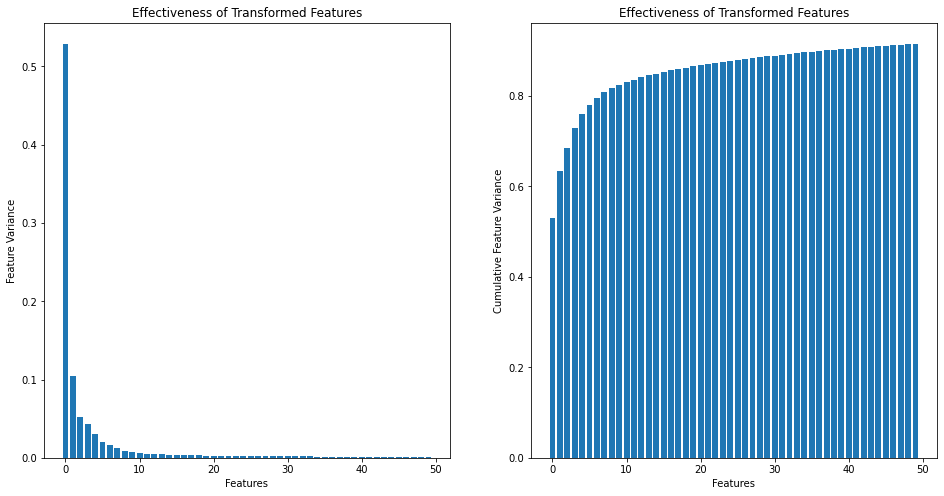

In [15]:
display_limit = 50
plt_features = normalized_singular_values[:display_limit]
plt_cumsum   = cumulative_sum[:display_limit]

plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
y_pos = np.arange(len(plt_features)) 
plt.bar(y_pos, plt_features, align='center', alpha=1.0)
plt.xlabel('Features')
plt.ylabel('Feature Variance')
plt.title('Effectiveness of Transformed Features') 


plt.subplot(1,2,2)
y_pos = np.arange(len(plt_cumsum)) 
plt.bar(y_pos, plt_cumsum, align='center', alpha=1.0)
plt.xlabel('Features')
plt.ylabel('Cumulative Feature Variance')
plt.title('Effectiveness of Transformed Features')
plt.show()

---

# Using Reduced Dataset Binary Classification Of Cells 

---

## Declare Graph Variables

Place to declare plave holders and variables for compute graph## 

In [18]:
SIGMA      = np.sqrt(2.0/rtrain_X.shape[0])
n_features = rtrain_X.shape[1]
n_labels   = 2


Weights = tf.Variable(tf.random.truncated_normal(shape=[n_features, n_labels], mean=3.0*SIGMA, 
                                          stddev=SIGMA, dtype=tf.float32), trainable=True)
Biases  = tf.Variable(tf.constant(value=SIGMA, dtype=tf.float32, shape=[n_labels]), 
                      trainable=True)
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
t_dataset = tf.placeholder(tf.float32, shape=(None, n_features), name='t_dataset');
t_labels  = tf.placeholder(tf.float32, shape=(None, n_labels), name='t_labels'); 

## Compute Graph
Construct a Logistic Regression model

In [19]:
predictions        = tf.matmul(t_dataset, Weights) + Biases

t_labels_cls       = tf.argmax(t_labels, axis=1)
predictions_cls    = tf.argmax(predictions, axis=1)
correct_prediction = tf.equal(predictions_cls, t_labels_cls)
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# change it to sigmoid_cross_entropy_with_logits
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=predictions,
                                                               labels=t_labels_cls)

## Hyper Parameters

In [20]:
# Hyper parameters
learning_rate = 100
training_epochs = 1000
display_step = 50

## Cost Function and Optimizer

In [21]:
cost = tf.reduce_mean(cross_entropy)

# Optimization algorithm
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

## Train the Model

In [22]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(optimizer, feed_dict={t_dataset:rtrain_X, t_labels:train_Y})

    #Display logs per epoch step
    if (epoch+1) % display_step == 0:
        c, a = sess.run([cost, accuracy], feed_dict={t_dataset:rtrain_X, t_labels:train_Y})
        print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), 
               "accuracy=", "{:.9f}".format(a))

print( "\nOptimization Finished!" )

Epoch: 0050 cost= 0.355270237 accuracy= 0.984517574
Epoch: 0100 cost= 0.168348834 accuracy= 0.987901151
Epoch: 0150 cost= 0.079123914 accuracy= 0.991182208
Epoch: 0200 cost= 0.047209054 accuracy= 0.992822707
Epoch: 0250 cost= 0.032033656 accuracy= 0.994053125
Epoch: 0300 cost= 0.023441350 accuracy= 0.995283484
Epoch: 0350 cost= 0.018625962 accuracy= 0.997026563
Epoch: 0400 cost= 0.015473415 accuracy= 0.997846842
Epoch: 0450 cost= 0.013251995 accuracy= 0.998256922
Epoch: 0500 cost= 0.011410426 accuracy= 0.998462021
Epoch: 0550 cost= 0.009930588 accuracy= 0.998564541
Epoch: 0600 cost= 0.008723330 accuracy= 0.998564541
Epoch: 0650 cost= 0.007571209 accuracy= 0.999282300
Epoch: 0700 cost= 0.006764661 accuracy= 0.999487340
Epoch: 0750 cost= 0.006032190 accuracy= 0.999487340
Epoch: 0800 cost= 0.005339480 accuracy= 0.999589860
Epoch: 0850 cost= 0.004677455 accuracy= 0.999589860
Epoch: 0900 cost= 0.004049042 accuracy= 0.999589860
Epoch: 0950 cost= 0.003485979 accuracy= 0.999589860
Epoch: 1000 

## Cost and Accuracy

In [23]:
rvalid_X = reduceDataset(valid_X)
# Find cost on training dataset.
t_cost, t_acc = sess.run([cost, accuracy], feed_dict={t_dataset:rtrain_X, t_labels:train_Y})
v_cost, v_acc = sess.run([cost, accuracy], feed_dict={t_dataset:rvalid_X, t_labels:valid_Y})

print ("Training   cost    =", t_cost)
print ("Validation cost    =", v_cost, '\n')
print("Training   Accuracy =", t_acc)
print("Validation Accuracy =", v_acc)

Training   cost    = 0.0030495985
Validation cost    = 0.03137679 

Training   Accuracy = 0.99958986
Validation Accuracy = 0.99507993


# Classifier

In [24]:
W = Weights.eval(session=sess)
B = Biases.eval(session=sess)

def classifier(X):
    #prediction = predictions_cls.eval(session=sess, feed_dict={t_dataset:X, t_labels:[[0, 0]]})
    prediction = np.argmax((np.matmul(X, W) + B), axis=1)
    cell_type = 'COMB' if (prediction == 0 ) else 'SQNC'
    return cell_type

# Test Few Cells

In [25]:
sample_cells = [os.path.join('..','data','2classes','COMB', 'AN2_1.mat'), 
                os.path.join('..','data','2classes','SQNC', 'FSDNQO_2.mat'),
                os.path.join('..','data','2classes','COMB', 'AN5_Y2_8_6.mat'),
                os.path.join('..','data','2classes','COMB', 'OAI22_TY2_16.mat'),
                os.path.join('..','data','2classes','COMB', 'MUX5_CTY2_24_1.mat'),
                os.path.join('..','data','2classes','SQNC', 'FSDPQO_6_2.mat'),
                os.path.join('..','data','2classes','COMB', 'MUX3_CTY2_32.mat'),
                os.path.join('..','data','2classes','SQNC', 'FSDNQ_V2_1.mat')]

for cell_file in sample_cells:
    cell_data = normalize(reformat(load_one_cell(cell_file)), data_mean, data_std)
    print (cell_file.ljust(40), 'CLASS is :', classifier(reduceDataset(cell_data)))
    
#Find all incorrectly predicted cells
# print('Cells with incorrect classification: ')
# incorrect_lbls = 0
# for label in ('COMB', 'SQNC'):
#     cell_files = os.listdir(os.path.join('..','data','2classes',label))
#     for cell_file in cell_files:
#         cell_data = normalize(reformat(
#             load_one_cell(
#                 os.path.join('..','data','2classes',label,cell_file)
#             )
#         ), data_mean, data_std)
#         predicted_label = classifier(reduceDataset(cell_data))
#         if ( label != predicted_label ):
#             print(cell_file, end=', ')
#             incorrect_lbls += 1
# print ('\nTotal number of incrrection prediction is ', incorrect_lbls)

..\data\2classes\COMB\AN2_1.mat          CLASS is : COMB
..\data\2classes\SQNC\FSDNQO_2.mat       CLASS is : SQNC
..\data\2classes\COMB\AN5_Y2_8_6.mat     CLASS is : SQNC
..\data\2classes\COMB\OAI22_TY2_16.mat   CLASS is : COMB
..\data\2classes\COMB\MUX5_CTY2_24_1.mat CLASS is : COMB
..\data\2classes\SQNC\FSDPQO_6_2.mat     CLASS is : SQNC
..\data\2classes\COMB\MUX3_CTY2_32.mat   CLASS is : COMB
..\data\2classes\SQNC\FSDNQ_V2_1.mat     CLASS is : SQNC


# Confusion Matrix

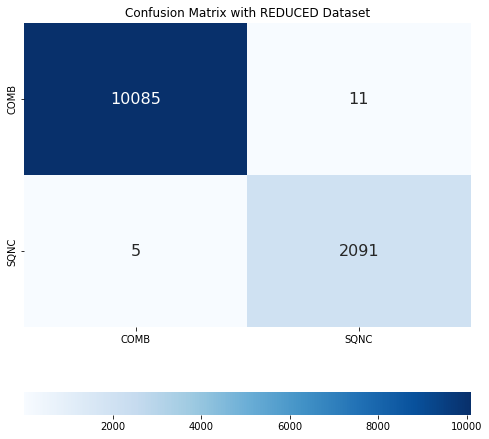

In [28]:
t_predictions = sess.run(predictions, feed_dict={t_dataset:reduceDataset(dataset), t_labels:labels})
cm = tf.confusion_matrix(labels=np.argmax(labels, axis=1), 
                         predictions=tf.argmax(t_predictions, axis=1), num_classes=2)
cm_ary = cm.eval(session=sess)

plt.figure(figsize = (8,8))
ax = sn.heatmap(cm_ary, xticklabels=['COMB', 'SQNC'], yticklabels=['COMB', 'SQNC'], 
                cmap="Blues", annot=True, fmt='d', annot_kws={"size": 16}, 
                cbar_kws={"orientation": "horizontal"})
ax.set_title('Confusion Matrix with REDUCED Dataset')

plt.show()


# Conclusion

Using PCA, we reduced our feature set set by over 77% as shown below with 99.97% of variance of our dataset kept.

---
__`dataset before (12192, 1755)`__

__`dataset  after (12192,  397)`__


We used this new dataset with reduced dimensionality as our new dataset for "Binary Classification Of Cells Using Logistic Regression". Resulting confusion matrix was very close to classes predicted with full dataset.



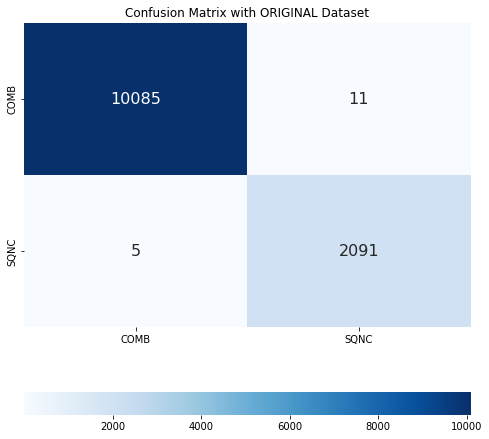

In [29]:
# Copy cm_ary from orig notebook on "Binary Classification Of Cells Using Logistic Regression".
cm_ary_orig = [[10085, 11], [5, 2091]]

plt.figure(figsize = (8,8))
ax = sn.heatmap(cm_ary, xticklabels=['COMB', 'SQNC'], yticklabels=['COMB', 'SQNC'], 
                cmap="Blues", annot=True, fmt='d', annot_kws={"size": 16}, 
                cbar_kws={"orientation": "horizontal"})
ax.set_title('Confusion Matrix with ORIGINAL Dataset')

#sn.set(font_scale=1.4)#for label size
plt.show()